In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_data_DCO = "/Users/eresther/Documents/Work/PhD/Codes/Data_DCO"
path_data_PSTH = "/Users/eresther/Documents/Work/PhD/Codes/Data_PSTH"

AREAS = ["A1", "dPEG", "VPr", "PFC"]
TASKS = ["PTD", "CLK"]
CTXS = ["a", "p"]
STIMS = ["R", "T"]
training = True

In [3]:
W = {area: None for area in AREAS}
for area in AREAS:
    W[area] = xr.open_dataarray(f"{path_data_DCO}/W_{training}_{area}.nc")

X = {area: None for area in AREAS}
for area in AREAS:
    X[area] = xr.open_dataarray(f"{path_data_PSTH}/Z_{training}_{area}_valid.nc")

In [4]:
# Decoders

W['VPr']

<xarray.DataArray 'W' (units: 127, time: 1, decoders: 33, folds: 3,
                       models: 101, batches: 5)> Size: 51MB
[6349365 values with dtype=float64]
Coordinates: (12/14)
  * units      (units) <U12 6kB 'avo109b-a1' 'lemon082b-d1' ... 'avo070a-c1'
  * time       (time) <U3 12B 'wdw'
  * decoders   (decoders) <U22 3kB 'task-p_bl' ... 'GoCLK-NoGoCLK-a/p_post'
  * folds      (folds) <U7 84B 'train_0' 'train_1' 'train_2'
  * models     (models) <U7 3kB 'true' 'perm_0' 'perm_1' ... 'perm_98' 'perm_99'
  * batches    (batches) int64 40B 0 1 2 3 4
    ...         ...
    task1      (decoders) <U3 396B ...
    ctx1       (decoders) <U1 132B ...
    stim1      (decoders) <U1 132B ...
    task0      (decoders) <U3 396B ...
    ctx0       (decoders) <U1 132B ...
    stim0      (decoders) <U1 132B ...
Attributes:
    area:      VPr
    training:  1
    errors:    0
    k:         3
    windows:   1

In [5]:
# Define useful variables
print(W['A1']['set_sizes'].values)
ntpts = len(X['A1']['time'].values)
nfolds = W['A1'].attrs['k']

def get_nbatches(area):
    return len(W[area]['batches'].values)

print(ntpts, nfolds, get_nbatches("A1"))


[24 24]
38 3 2


In [6]:
# Keep true models and relevant decoders
W_ = {area: W[area].sel(decoders='task-a_bl/p_bl', models='true') for area in AREAS}

W_['A1']

<xarray.DataArray 'W' (units: 26, time: 1, folds: 3, batches: 2)> Size: 1kB
[156 values with dtype=float64]
Coordinates: (12/14)
  * units      (units) <U10 1kB 'lem046d-j1' 'avo047a-u1' ... 'lem045c-p1'
  * time       (time) <U3 12B 'wdw'
    decoders   <U22 88B 'task-a_bl/p_bl'
  * folds      (folds) <U7 84B 'train_0' 'train_1' 'train_2'
    models     <U7 28B 'true'
  * batches    (batches) int64 16B 0 1
    ...         ...
    task1      <U3 12B ...
    ctx1       <U1 4B ...
    stim1      <U1 4B ...
    task0      <U3 12B ...
    ctx0       <U1 4B ...
    stim0      <U1 4B ...
Attributes:
    area:      A1
    training:  1
    errors:    0
    k:         3
    windows:   1

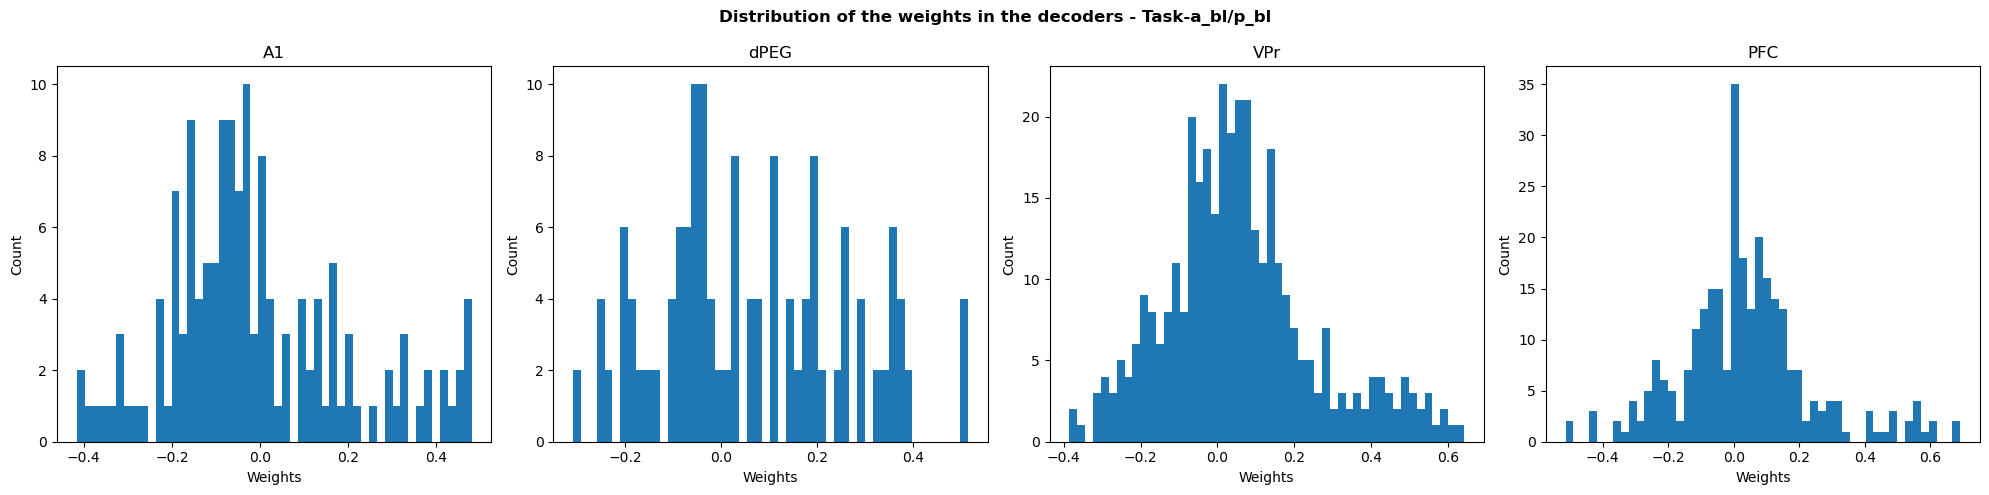

In [7]:
# Plot the distribution of the weigths across units in the decoders

nrows = 1
ncols = len(AREAS)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

plt.suptitle("Distribution of the weights in the decoders - Task-a_bl/p_bl", weight='bold')
for i, area in enumerate(AREAS):
    axs[i].hist(W_[area].values.flatten(), bins=50)
    axs[i].set_title(area)
    axs[i].set_xlabel("Weights")
    axs[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [8]:
# Average weights across folds and batches
W_avg = {area: W_[area].mean(dim=['folds', 'batches']) for area in AREAS} # NaNs are ignored
# For each area, keep the units with the 10% highest and lowest weights
q_low = {area: W_avg[area].quantile(0.1) for area in AREAS} 
q_high = {area: W_avg[area].quantile(0.9) for area in AREAS}

print(q_low['A1'])

# Extract the units with the 10% highest and lowest weights
U_low = {area: W_avg[area] < q_low[area] for area in AREAS}
U_high = {area: W_avg[area] > q_high[area] for area in AREAS}

U_low['A1']

<xarray.DataArray 'W' ()> Size: 8B
array(-0.20152172)
Coordinates:
    quantile  float64 8B 0.1


<xarray.DataArray 'W' (units: 26, time: 1)> Size: 26B
array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True]])
Coordinates:
  * units     (units) <U10 1kB 'lem046d-j1' 'avo047a-u1' ... 'lem045c-p1'
  * time      (time) <U3 12B 'wdw'
    decoders  <U22 88B 'task-a_bl/p_bl'
    models    <U7 28B 'true'
    wdw       <U6 24B ...
    task1     <U3 12B ...
    ctx1      <U1 4B ...
    stim1     <U1 4B ...
    task0     <U3 12B ...
    ctx0      <U1 4B ...
    stim0     <U1 4B ...
    quantile  float64 8B 0.1

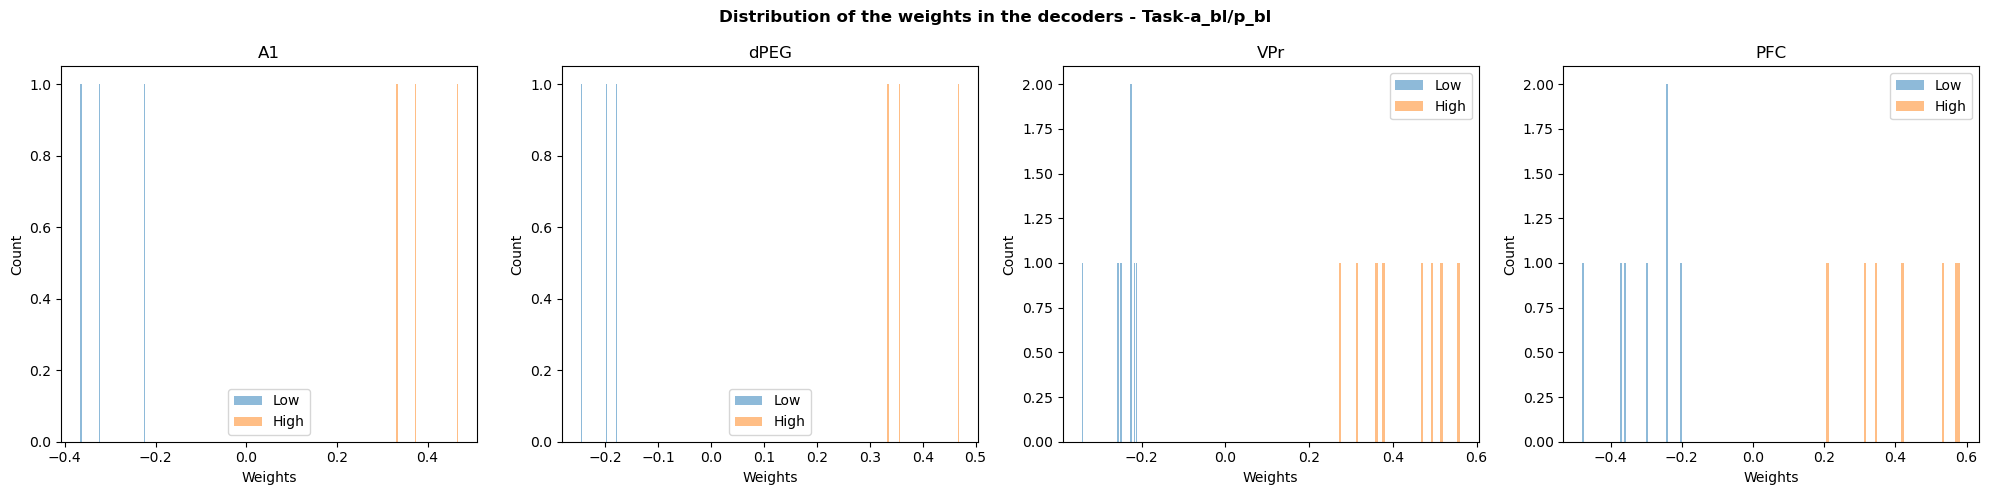

In [9]:
# Plot the new distribution of the weigths across the retained units in the decoders

nrows = 1
ncols = len(AREAS)

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
fig.suptitle("Distribution of the weights in the decoders - Task-a_bl/p_bl", weight='bold')

for i, area in enumerate(AREAS):
    axs[i].hist(W_avg[area].values[U_low[area]], bins=50, alpha=0.5, label='Low')
    axs[i].hist(W_avg[area].values[U_high[area]], bins=50, alpha=0.5, label='High')
    axs[i].set_title(area)
    axs[i].set_xlabel("Weights")
    axs[i].set_ylabel("Count")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [10]:
# Compute the average activities of the retained units in the different conditions
X_low = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
X_high = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_low = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
STD_high = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_low = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}
SEM_high = {area: {task: {ctx: {stim: None for stim in STIMS} for ctx in CTXS} for task in TASKS} for area in AREAS}

for area in AREAS:
    for f in range(nfolds):
        print(f"*** Area: {area}, Fold: {f} ***")
        X_area = X[area].sel(trials=X[area][f'test_{f}'].values) # retain the right test fold (nunits, ntpts, ntrials_test_fold_f)
        print(f"Shape of X_area: {X_area.shape}")
        for t in TASKS:
            for c in CTXS:
                for s in STIMS:
                    print(f"-- Task: {t}, Context: {c}, Stimulus: {s}")
                    x = X_area.sel(trials=(X_area['task'].values==t)&(X_area['ctx'].values==c)&(X_area['stim'].values==s)).values # (nunits, ntpts, ntrials_condition)
                    print(f"Shape of x: {x.shape}")
                    for U_pop, X_pop, STD_pop, SEM_pop in zip([U_low, U_high], [X_low, X_high], [STD_low, STD_high], [SEM_low, SEM_high]):
                        print(f"Shape of U_pop: {U_pop[area].shape}")
                        print(f"Shape of U_pop[area].values.flatten(): {U_pop[area].values.flatten().shape}")
                        x_pop = x[U_pop[area].values.flatten()] # (nunits_pop, ntpts, ntrials_condition)
                        # Compute the average activity across units
                        X_avg = np.nanmean(x_pop, axis=0) # (ntpts, ntrials_condition)
                        print(f"Shape of X_avg: {X_avg.shape}")
                        # Check the number of NaNs
                        # Compute the mean activity across trials 
                        X_pop[area][t][c][s] = np.nanmean(X_avg, axis=1)
                        # Compute the standard deviation
                        STD_pop[area][t][c][s] = np.nanstd(X_avg, axis=1)
                        # Compute the standard error of the mean
                        SEM_pop[area][t][c][s] = STD_pop[area][t][c][s] / np.sqrt(x_pop.shape[0])

*** Area: A1, Fold: 0 ***
Shape of X_area: (26, 38, 50)
-- Task: PTD, Context: a, Stimulus: R
Shape of x: (26, 38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
-- Task: PTD, Context: a, Stimulus: T
Shape of x: (26, 38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
-- Task: PTD, Context: p, Stimulus: R
Shape of x: (26, 38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
-- Task: PTD, Context: p, Stimulus: T
Shape of x: (26, 38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].values.flatten(): (26,)
Shape of X_avg: (38, 5)
Shape of U_pop: (26, 1)
Shape of U_pop[area].

In [11]:
# Define colors and linestyles
colors = {'PTD': {'a': {'R': 'blue', 'T': 'red'}, 'p': {'R': 'navy', 'T': 'tomato'}},
          'CLK': {'a': {'R': 'turquoise', 'T': 'magenta'}, 'p': {'R': 'purple', 'T': 'orange'}}}
linestyles = {'a': '-', 'p': '--'}

Area: A1, Task: PTD, Pop: low, Stim: R, Ctx: a
Area: A1, Task: PTD, Pop: low, Stim: R, Ctx: p
Area: A1, Task: PTD, Pop: low, Stim: T, Ctx: a
Area: A1, Task: PTD, Pop: low, Stim: T, Ctx: p
Area: A1, Task: PTD, Pop: high, Stim: R, Ctx: a
Area: A1, Task: PTD, Pop: high, Stim: R, Ctx: p
Area: A1, Task: PTD, Pop: high, Stim: T, Ctx: a
Area: A1, Task: PTD, Pop: high, Stim: T, Ctx: p
Area: A1, Task: CLK, Pop: low, Stim: R, Ctx: a
Area: A1, Task: CLK, Pop: low, Stim: R, Ctx: p
Area: A1, Task: CLK, Pop: low, Stim: T, Ctx: a
Area: A1, Task: CLK, Pop: low, Stim: T, Ctx: p
Area: A1, Task: CLK, Pop: high, Stim: R, Ctx: a
Area: A1, Task: CLK, Pop: high, Stim: R, Ctx: p
Area: A1, Task: CLK, Pop: high, Stim: T, Ctx: a
Area: A1, Task: CLK, Pop: high, Stim: T, Ctx: p
Area: dPEG, Task: PTD, Pop: low, Stim: R, Ctx: a
Area: dPEG, Task: PTD, Pop: low, Stim: R, Ctx: p
Area: dPEG, Task: PTD, Pop: low, Stim: T, Ctx: a
Area: dPEG, Task: PTD, Pop: low, Stim: T, Ctx: p
Area: dPEG, Task: PTD, Pop: high, Stim: R, C

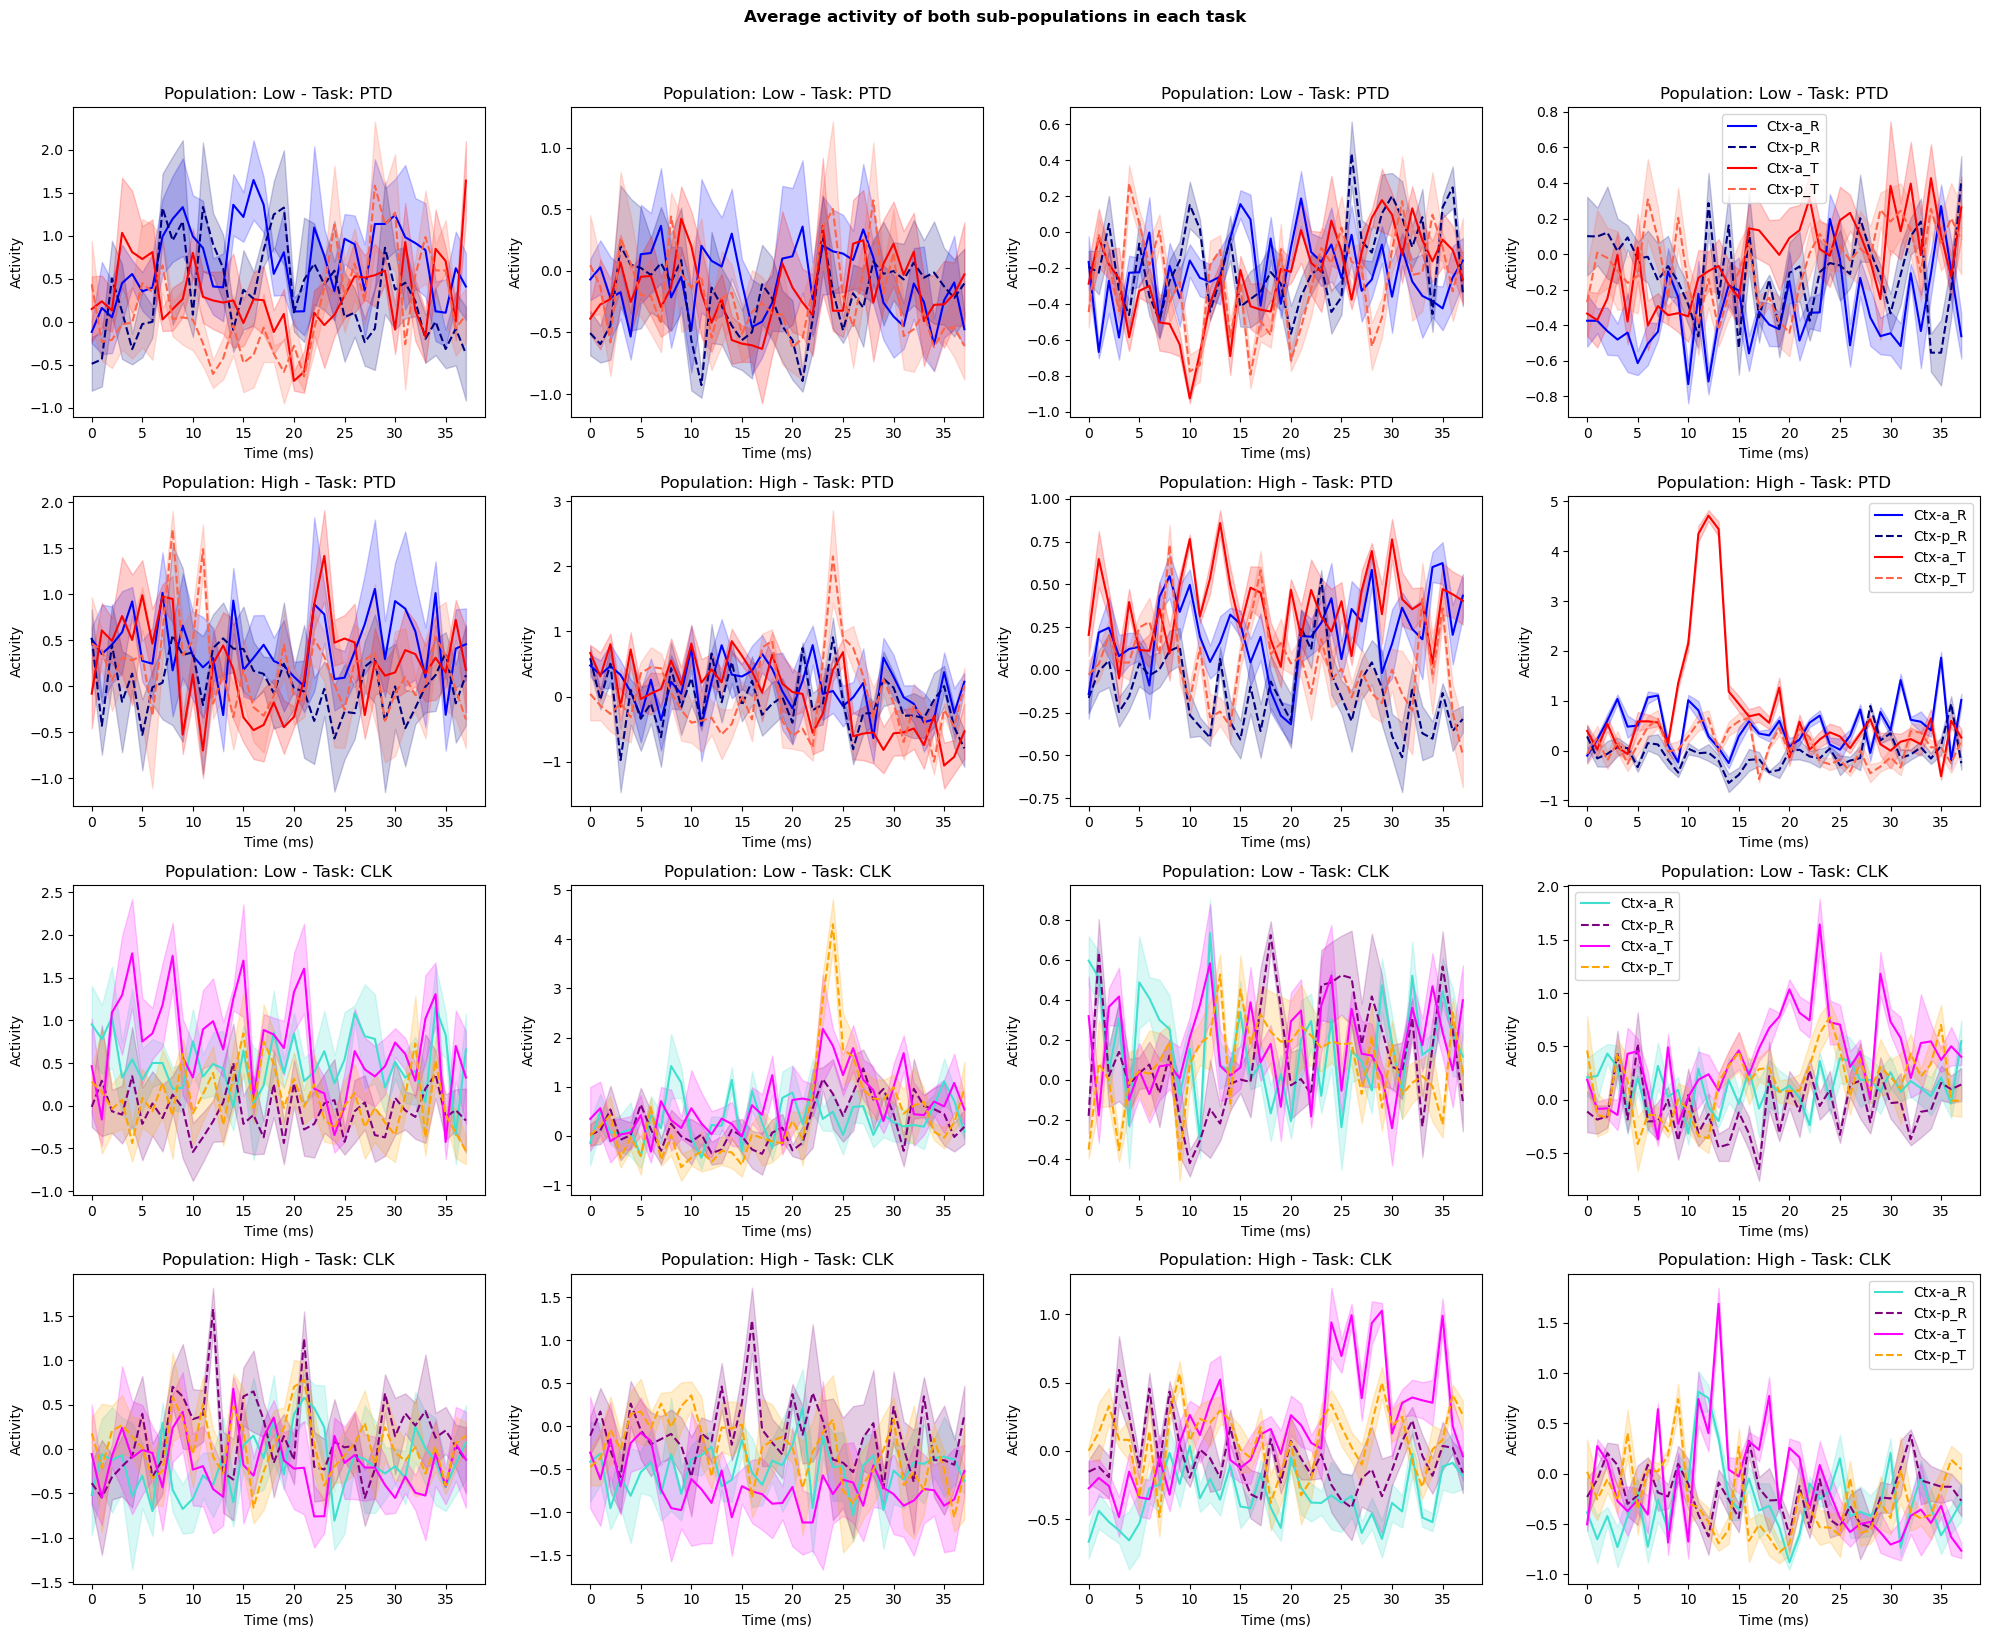

In [12]:
# FIG1: Time courses
pops = ['low', 'high']
npops = len(pops)
nrows = len(pops)*len(TASKS) # 2 populations, 2 tasks
ncols = len(AREAS)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.suptitle("Average activity of both sub-populations in each task", weight='bold', y=1.02)


for i, area in enumerate(AREAS):
    for j, task in enumerate(TASKS):
        for k, (pop, X_pop) in enumerate(zip(pops, [X_low, X_high])):
            ax = axes[j*npops+k, i]
            for l, stim in enumerate(STIMS):
                for ctx in CTXS:
                    ax.plot(X_pop[area][task][ctx][stim], color=colors[task][ctx][stim], ls=linestyles[ctx], label=f"Ctx-{ctx}_{stim}")
                    ax.fill_between(range(ntpts), X_pop[area][task][ctx][stim]-SEM_low[area][task][ctx][stim], X_pop[area][task][ctx][stim]+SEM_low[area][task][ctx][stim], color=colors[task][ctx][stim], alpha=0.2)
            ax.set_title(f"Population: {pop.capitalize()} - Task: {task}")
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("Activity")
            if area=='PFC':
                ax.legend()

plt.tight_layout()
plt.show()

In [17]:
# Save U_low and U_high in numpy arrays

path_save = "/Users/eresther/Documents/Work/multitask-context-dependent-behavior/notebooks_explo/data"

for area in AREAS:
    np.save(f"{path_save}/U_low_{area}.npy", U_low[area].values.flatten())
    np.save(f"{path_save}/U_high_{area}.npy", U_high[area].values.flatten())

